In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/olist-datasets/olist_customers_dataset.csv
/kaggle/input/olist-datasets/olist_sellers_dataset.csv
/kaggle/input/olist-datasets/olist_order_reviews_dataset.csv
/kaggle/input/olist-datasets/olist_order_items_dataset.csv
/kaggle/input/olist-datasets/olist_products_dataset.csv
/kaggle/input/olist-datasets/olist_geolocation_dataset.csv
/kaggle/input/olist-datasets/product_category_name_translation.csv
/kaggle/input/olist-datasets/olist_orders_dataset.csv
/kaggle/input/olist-datasets/olist_order_payments_dataset.csv


# Product Recommendation for Revenue Growth

This notebook analyzes customer-level purchase behavior in the
Olist Brazilian e-commerce dataset to evaluate whether
personalized product recommendations can drive revenue growth
more effectively than uniform recommendation strategies.

Rather than optimizing a complex machine learning model,
this project focuses on understanding:

- Who should be targeted
- What should be recommended
- When recommendations should be emphasized

The analysis is structured around three testable hypotheses
related to customer value concentration, category preference,
and temporal purchasing behavior.


## Data Loading

The Olist dataset consists of multiple normalized tables.
Only the tables required for customer purchase analysis
are loaded in this notebook.

Raw data files are not included in the repository due to size
and licensing constraints. See `data/README.md` for details.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
olist_customers = pd.read_csv('/kaggle/input/olist-datasets/olist_customers_dataset.csv')
olist_orders = pd.read_csv('/kaggle/input/olist-datasets/olist_orders_dataset.csv')
olist_order_items = pd.read_csv('/kaggle/input/olist-datasets/olist_order_items_dataset.csv')
olist_products = pd.read_csv('/kaggle/input/olist-datasets/olist_products_dataset.csv')

## Data Integration

The `order_items` table is used as the base transactional unit.
Only delivered orders are retained to ensure revenue validity.

Customer and product metadata are joined sequentially
to construct a comprehensive purchase history table.


In [4]:
orders_delivered = olist_orders[
    olist_orders['order_status'] == 'delivered'
][['order_id', 'customer_id', 'order_purchase_timestamp']]

purchase_history = (
    olist_order_items
    .merge(orders_delivered, on='order_id', how='inner')
    .merge(
        olist_customers[['customer_id', 'customer_unique_id', 'customer_state']],
        on='customer_id',
        how='left'
    )
    .merge(
        olist_products[['product_id', 'product_category_name']],
        on='product_id',
        how='left'
    )
)

purchase_history['order_purchase_timestamp'] = pd.to_datetime(
    purchase_history['order_purchase_timestamp']
)

purchase_history['customer_key'] = (
    purchase_history['customer_unique_id']
    .astype('category')
    .cat.codes
)

purchase_history = purchase_history[[
    'customer_key',
    'customer_unique_id',
    'order_id',
    'product_id',
    'product_category_name',
    'price',
    'order_purchase_timestamp',
    'customer_state'
]]


## Customer Profile Construction

Customer-level features are derived by aggregating
transaction-level purchase history.

These features capture:
- Customer value
- Purchase frequency
- Price sensitivity
- Category preference
- Temporal purchasing behavior


In [5]:
customer_summary = (
    purchase_history
    .groupby(['customer_key', 'customer_unique_id'])
    .agg(
        total_spent=('price', 'sum'),
        purchase_count=('order_id', 'nunique')
    )
    .reset_index()
)

vip_threshold = customer_summary['total_spent'].quantile(0.8)

customer_summary['customer_type'] = customer_summary['total_spent'].apply(
    lambda x: 'VIP' if x >= vip_threshold else 'Non-VIP'
)


In [6]:
price_features = (
    purchase_history
    .groupby('customer_key')
    .agg(
        avg_price=('price', 'mean'),
        max_price=('price', 'max'),
        price_std=('price', 'std')
    )
    .reset_index()
)


In [7]:
purchase_sorted = purchase_history.sort_values(
    ['customer_key', 'order_purchase_timestamp']
)

purchase_sorted['prev_purchase'] = (
    purchase_sorted
    .groupby('customer_key')['order_purchase_timestamp']
    .shift(1)
)

purchase_sorted['repurchase_gap_days'] = (
    purchase_sorted['order_purchase_timestamp'] -
    purchase_sorted['prev_purchase']
).dt.days

repurchase_features = (
    purchase_sorted
    .groupby('customer_key')
    .agg(
        avg_repurchase_gap=('repurchase_gap_days', 'mean'),
        purchase_frequency=('order_id', 'nunique')
    )
    .reset_index()
)


In [8]:
purchase_history['month'] = purchase_history['order_purchase_timestamp'].dt.month
purchase_history['is_sale_season'] = purchase_history['month'].isin([11, 12])

sale_features = (
    purchase_history
    .groupby('customer_key')
    .agg(
        sale_purchase_ratio=('is_sale_season', 'mean')
    )
    .reset_index()
)


In [9]:
customer_category = (
    purchase_history
    .groupby(['customer_key', 'product_category_name'])
    .size()
    .reset_index(name='category_count')
)

top_category = (
    customer_category
    .sort_values(['customer_key', 'category_count'], ascending=[True, False])
    .drop_duplicates('customer_key')
    .rename(columns={'product_category_name': 'top_category'})
    [['customer_key', 'top_category']]
)


In [10]:
customer_profile = (
    customer_summary
    .merge(price_features, on='customer_key', how='left')
    .merge(repurchase_features, on='customer_key', how='left')
    .merge(sale_features, on='customer_key', how='left')
    .merge(top_category, on='customer_key', how='left')
)


## Hypothesis 1
Customer contribution to revenue is not evenly distributed.


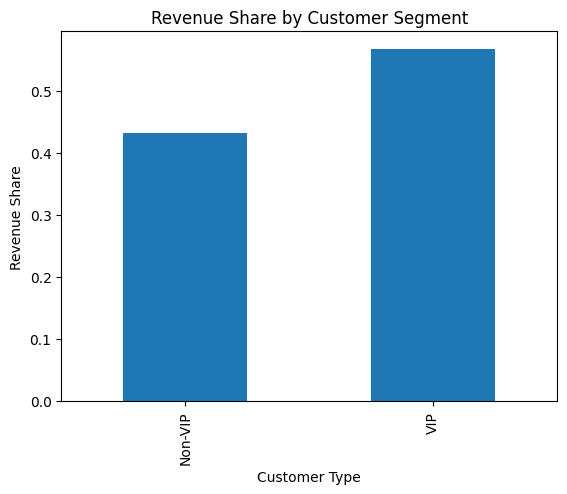

In [11]:
revenue_by_type = customer_summary.groupby('customer_type')['total_spent'].sum()
revenue_share = revenue_by_type / revenue_by_type.sum()

revenue_share.plot(kind='bar')
plt.title('Revenue Share by Customer Segment')
plt.ylabel('Revenue Share')
plt.xlabel('Customer Type')
plt.show()


## Hypothesis 2
Customers repeatedly purchase products from specific categories.


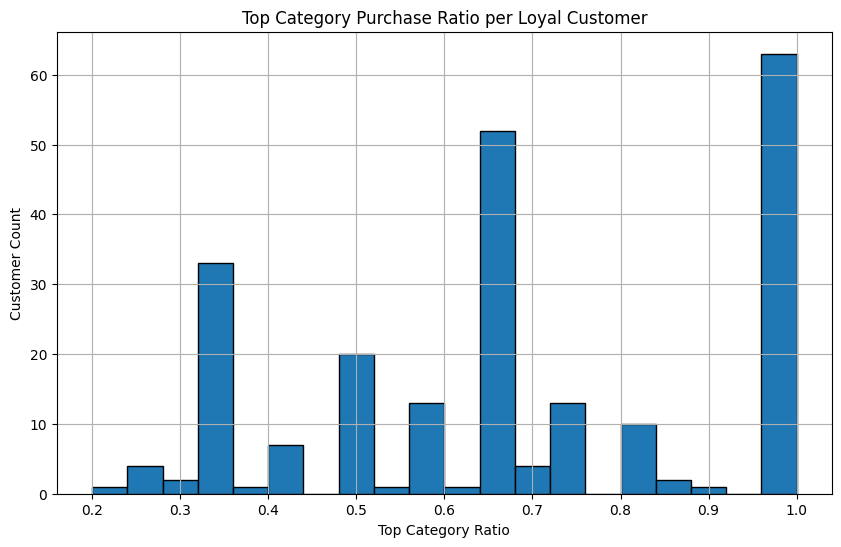

In [12]:
loyal_customers = customer_summary[
    customer_summary['purchase_count'] >= 3
]['customer_key']

loyal_history = purchase_history[
    purchase_history['customer_key'].isin(loyal_customers)
]

category_counts = (
    loyal_history
    .groupby(['customer_key', 'product_category_name'])
    .size()
    .rename("count") 
)

category_ratio = (
    category_counts
    .groupby(level=0, group_keys=False) 
    .apply(lambda x: x / x.sum())
    .reset_index(name='ratio') 
)

top_ratio = (
    category_ratio
    .groupby('customer_key')['ratio']
    .max()
    .reset_index() 
)

plt.figure(figsize=(10, 6))
top_ratio['ratio'].hist(bins=20, edgecolor='black') 
plt.title('Top Category Purchase Ratio per Loyal Customer')
plt.xlabel('Top Category Ratio')
plt.ylabel('Customer Count')
plt.show()

## Hypothesis 3
Revenue variation is driven primarily by order count, not price.


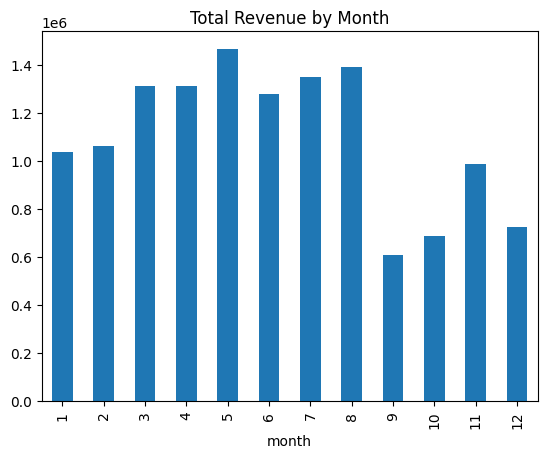

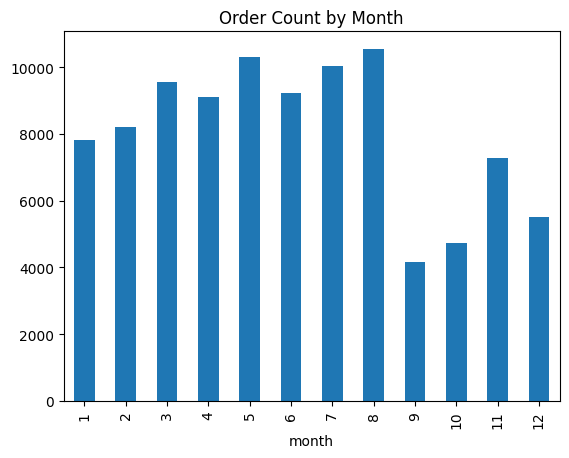

In [13]:
monthly_revenue = purchase_history.groupby('month')['price'].sum()
monthly_orders = purchase_history.groupby('month')['order_id'].nunique()

monthly_revenue.plot(kind='bar')
plt.title('Total Revenue by Month')
plt.show()

monthly_orders.plot(kind='bar')
plt.title('Order Count by Month')
plt.show()


## Baseline Recommendation Model

A simple, interpretable rule-based recommender is implemented.
VIP customers receive revenue-based recommendations,
while Non-VIP customers receive popularity-based recommendations.


In [14]:
category_product_popular = (
    purchase_history
    .groupby(['product_category_name', 'product_id'])
    .size()
    .reset_index(name='purchase_count')
)

category_product_revenue = (
    purchase_history
    .groupby(['product_category_name', 'product_id'])['price']
    .sum()
    .reset_index(name='total_revenue')
)

TOP_K = 5


In [15]:
def recommend_products(customer_key, top_n=3):
    customer_row = customer_summary[
        customer_summary['customer_key'] == customer_key
    ]
    
    if customer_row.empty:
        return None
    
    customer_type = customer_row['customer_type'].values[0]
    
    category_row = top_category[
        top_category['customer_key'] == customer_key
    ]
    
    if category_row.empty:
        return None
    
    category = category_row['top_category'].values[0]
    
    if customer_type == 'VIP':
        candidates = category_product_revenue
        metric = 'total_revenue'
    else:
        candidates = category_product_popular
        metric = 'purchase_count'
    
    return (
        candidates[candidates['product_category_name'] == category]
        .sort_values(metric, ascending=False)
        .head(top_n)['product_id']
        .tolist()
    )


## Summary

This notebook demonstrates how customer-level behavioral analysis
can inform revenue-driven recommendation strategies.

Key takeaways:
- Revenue is driven by a small subset of high-value customers
- Customers exhibit strong category preferences
- Revenue fluctuations are driven by order frequency, not price

These findings support the use of customer-specific,
time-aware recommendation strategies over uniform approaches.
